In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [24]:
#data_dir = '/home/a4000/Data/nhungnth/car_logo_classify/Dataset'
TRAIN_RATIO = 0.8

train_dir = '/home/ubuntu/ds-veritone-energy/train'
test_dir = '/home/ubuntu/ds-veritone-energy/nhung/Efficientnet/test'


In [4]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['ford', 'honda', 'hyundai', 'kia', 'kia-new', 'lexus', 'mazda', 'mercedes', 'mitsubishi', 'opel', 'toyota', 'volkswagen']


In [28]:
# TRAIN_RATIO = 0.9

# train_dir = os.path.join(data_dir, 'train')
# test_dir = os.path.join(data_dir, 'test')

# if os.path.exists(train_dir):
#     shutil.rmtree(train_dir) 
# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)
    
# os.makedirs(train_dir)
# os.makedirs(test_dir)

# classes = os.listdir(data_dir)

# for c in classes:
    
#     class_dir = os.path.join(data_dir, c)
    
#     images = os.listdir(class_dir)
       
#     n_train = int(len(images) * TRAIN_RATIO)
    
#     train_images = images[:n_train]
#     test_images = images[n_train:]
    
#     os.makedirs(os.path.join(train_dir, c), exist_ok = True)
#     os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
#     for image in train_images:
#         image_src = os.path.join(class_dir, image)
#         image_dst = os.path.join(train_dir, c, image) 
#         shutil.copyfile(image_src, image_dst)
        
#     for image in test_images:
#         image_src = os.path.join(class_dir, image)
#         image_dst = os.path.join(test_dir, c, image) 
#         shutil.copyfile(image_src, image_dst)

In [57]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image  
    
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [25]:
train_data = datasets.ImageFolder(root = train_dir, transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4358, 0.4025, 0.4209])
Calculated stds: tensor([0.2184, 0.2210, 0.2148])


In [58]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(10),
                           transforms.RandomPerspective(distortion_scale=0.3, p=0.25),
                           transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                           transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.5)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms


BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [30]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 55
Number of validation examples: 14
Number of testing examples: 1783


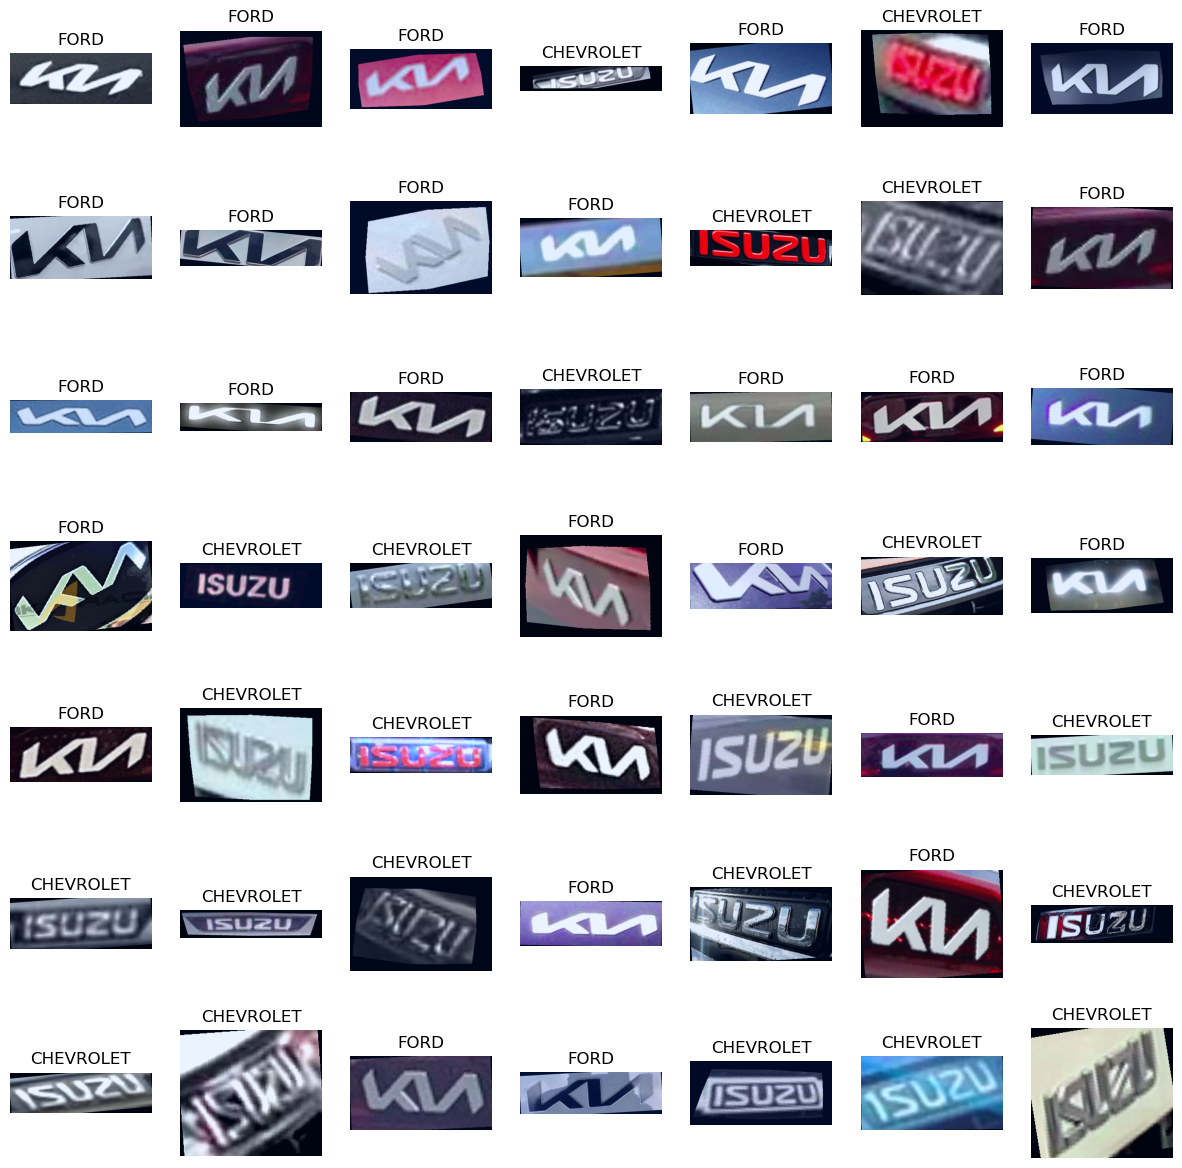

In [60]:
N_IMAGES = 50

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

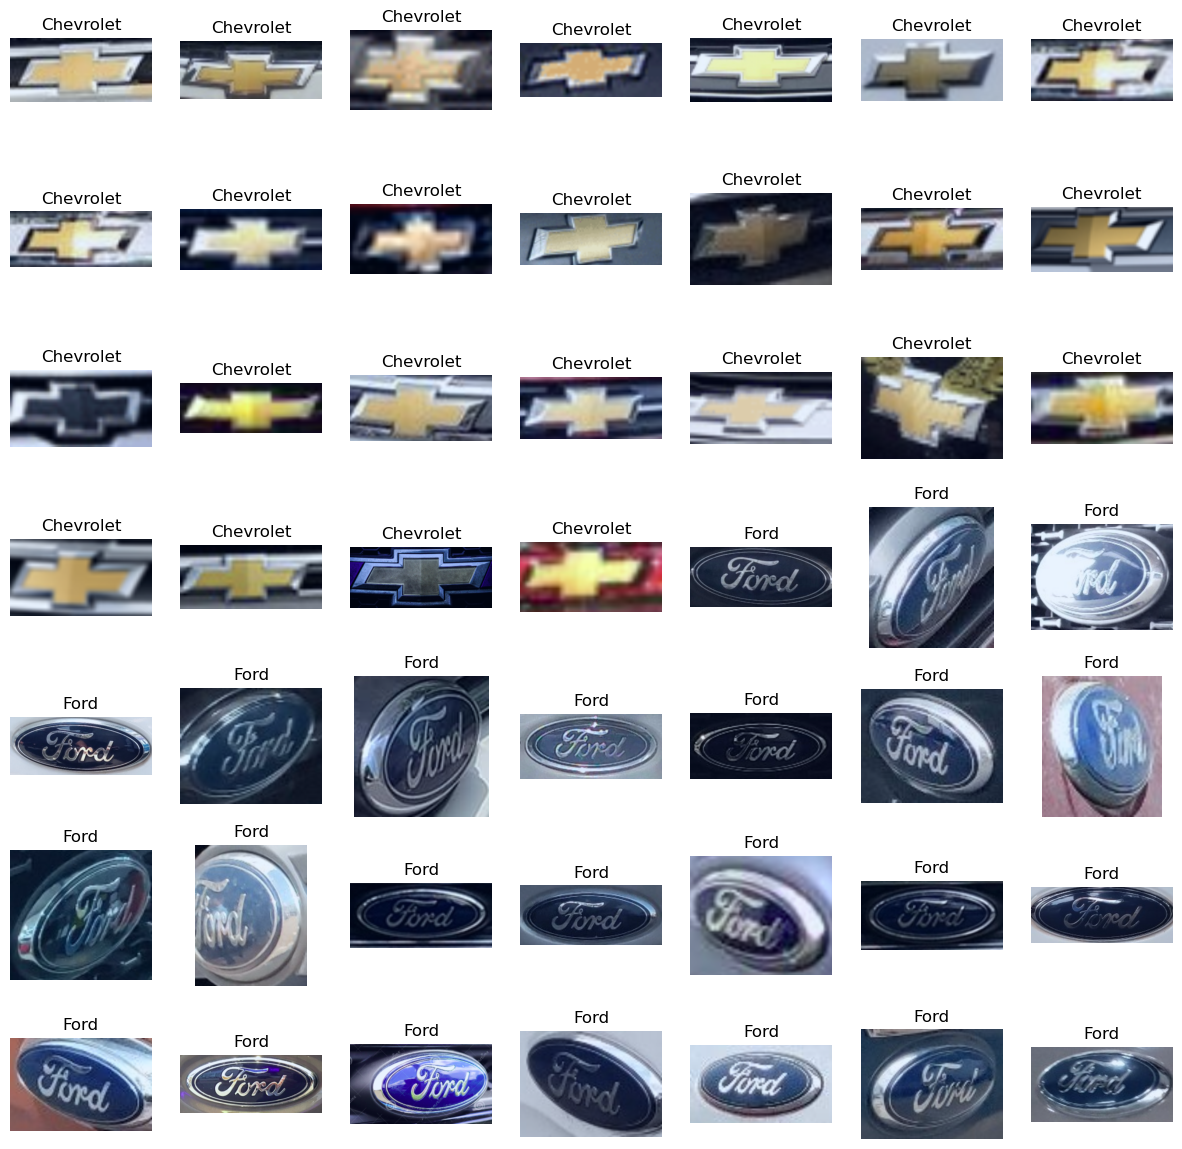

In [22]:
N_IMAGES = 50

images, labels = zip(*[(image, label) for image, label in 
                           [test_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes

plot_images(images, labels, classes)